## HuggingFace PixArt Alpha (256x256, 512x512 square resolution) Inference on Trn1 / Inf2

**Introduction**

This notebook demonstrates how to compile and run the HuggingFace PixArt Alpha (256x256 && 512x512 square resolution) models for accelerated inference on Neuron.

This Jupyter notebook should be run on an Inf2 instance (`inf2.8xlarge` or larger)

Verify that this Jupyter notebook is running the Python kernel environment that was set up according to the [PyTorch Installation Guide](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/setup/torch-neuronx.html#setup-torch-neuronx). You can select the kernel from the 'Kernel -> Change Kernel' option on the top of this Jupyter notebook page.

**Install Dependencies**

This tutorial requires the following pip packages to be installed:
- `torch-neuronx`
- `neuronx-cc`
- `diffusers==0.29.2`
- `sentencepiece==0.2.0`
- `transformers==4.36.2`
- `ml_dtypes`

`torch-neuronx` and `neuronx-cc` will be installed when you configure your environment following the Inf2 setup guide. The remaining dependencies can be installed below:

%env TOKENIZERS_PARALLELISM=True #Supresses tokenizer warnings making errors easier to detect
!pip install diffusers==0.29.2 transformers==4.36.2 

#### Imports

In [2]:
import os

os.environ["NEURON_FUSE_SOFTMAX"] = "1"
os.environ["NEURON_CUSTOM_SILU"] = "1"

import copy
import diffusers
import math
import numpy as npy
import time
import torch
import torch_neuronx
import torch.nn as nn
import torch.nn.functional as F

from diffusers import PixArtAlphaPipeline
from IPython.display import clear_output
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from torch import nn

# Define datatype
DTYPE = torch.bfloat16

clear_output(wait=False)

**Define utility classes and functions**

The following section defines some utility classes and functions. In particular, we define a double-wrapper for the backbone transformer and another wrapper for the text encoder. These wrappers enable `torch_neuronx.trace` to trace the wrapped models for compilation with the Neuron compiler. In addition, the `neuron_scaled_dot_product_attention` utility function performs optimized attention score calculation and is used to replace the original `scaled_dot_product_attention` function via a monkey patch (see the next code block under "Compile backbone and save" for usage). Finally, a `f32Wrapper` module is defined and performs the norm operations in fp32 precision (see the last code block under for usage) for the vae decoder.

In [3]:
import torch
from torch import nn
from transformers.models.t5.modeling_t5 import T5EncoderModel
from diffusers import Transformer2DModel
from diffusers.models.autoencoders.vae import Decoder

import math

def neuron_scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=None, is_causal=None):
  orig_shape = None
  if len(query.shape) == 4:
    orig_shape = query.shape
    def to3d(x):
      return x.reshape(-1, x.shape[2], x.shape[3])
    query, key, value = map(to3d, [query, key, value])
  if query.size() == key.size():
    attention_scores = torch.bmm(key, query.transpose(-1, -2)) * (
      1 / math.sqrt(query.size(-1))
    )
    attention_probs = attention_scores.softmax(dim=1).permute(0, 2, 1)
  else:
    attention_scores = torch.bmm(query, key.transpose(-1, -2)) * (
      1 / math.sqrt(query.size(-1))
    )
    attention_probs = attention_scores.softmax(dim=-1)
  attn_out = torch.bmm(attention_probs, value)
  if orig_shape:
    attn_out = attn_out.reshape(
      orig_shape[0], orig_shape[1], attn_out.shape[1], attn_out.shape[2]
    )
  return attn_out

class TracingT5Wrapper(nn.Module):
  def __init__(self, t: T5EncoderModel, seqlen: int):
    super().__init__()
    self.t = t
    self.device = t.device
    precomputed_bias = self.t.encoder.block[0].layer[0].SelfAttention.compute_bias(seqlen, seqlen)
    self.t.encoder.block[0].layer[0].SelfAttention.compute_bias = lambda *args, **kwargs: precomputed_bias
  def forward(self, text_input_ids, prompt_attention_mask):
    return self.t(
      text_input_ids, 
      attention_mask=prompt_attention_mask
    )

class InferenceTextEncoderWrapper(nn.Module):
  def __init__(self, dtype, t: T5EncoderModel, seqlen: int):
    super().__init__()
    self.dtype = dtype
    self.device = t.device
    self.t = t
  def forward(self, text_input_ids, attention_mask=None):
    return [self.t(text_input_ids, attention_mask)['last_hidden_state'].to(self.dtype)]

class TracingTransformerWrapper(nn.Module):
  def __init__(self, transformer):
    super().__init__()
    self.transformer = transformer
    self.config = transformer.config
    self.dtype = transformer.dtype
    self.device = transformer.device    
  def forward(self, hidden_states=None, encoder_hidden_states=None, timestep=None, encoder_attention_mask=None, **kwargs):
    return self.transformer(
      hidden_states=hidden_states, 
      encoder_hidden_states=encoder_hidden_states, 
      timestep=timestep, 
      encoder_attention_mask=encoder_attention_mask,
      added_cond_kwargs={"resolution": None, "aspect_ratio": None},
      return_dict=False)

class InferenceTransformerWrapper(nn.Module):
  def __init__(self, transformer: Transformer2DModel):
    super().__init__()
    self.transformer = transformer
    self.config = transformer.config
    self.dtype = transformer.dtype
    self.device = transformer.device
  def forward(self, hidden_states, encoder_hidden_states=None, timestep=None, 
              encoder_attention_mask=None, added_cond_kwargs=None,
              return_dict=False):
    output = self.transformer(
      hidden_states, 
      encoder_hidden_states, 
      timestep, 
      encoder_attention_mask)
    return output

class SimpleWrapper(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = model
  def forward(self, x):
    output = self.model(x)
    return output

class f32Wrapper(nn.Module):
  def __init__(self, original):
    super().__init__()
    self.original = original
  def forward(self, x):
    t = x.dtype
    y = x.to(torch.float32)
    output = self.original(y)
    return output.type(t)

**Compile the model into an optimized TorchScript and save the TorchScript**

In the following section, we will compile parts of the PixArt Alpha pipeline for execution on Neuron. Note that this only needs to be done once: After you have compiled and saved the model by running the following section of code, you can reuse it any number of times without having to recompile. In particular, we will compile:
1. The T5 text encoder;
2. The VAE decoder;
3. The backbone transformer, and
4. The VAE post_quant_conv
These blocks are chosen because they represent the bulk of the compute in the pipeline, and performance benchmarking has shown that running them on Neuron yields significant performance benefit.

Several points worth noting are:
1. In order to save RAM (these compiles need lots of RAM!), before tracing each model, we make a deepcopy of the part of the pipeline (i.e. the transformer or the VAE decoder) that is to be traced, and then delete the pipeline object from memory with `del pipe`. This trick allows the compile to succeed on instance types with a smaller amount of RAM.
2. When compiling each part of the pipeline, we need to pass `torch_neuronx.trace` sample input(s), When there are multiple inputs, they are passed together as a tuple. For details on how to use `torch_neuronx.trace`, please refer to our documentation here: https://awsdocs-neuron.readthedocs-hosted.com/en/latest/frameworks/torch/torch-neuronx/api-reference-guide/inference/api-torch-neuronx-trace.html
3. Note that while compiling the backbone transformer, we make use of the double-wrapper structure defined above. In addition, we also use the optimized `neuron_scaled_dot_product_attention` function to replace the original `scaled_dot_product_attention` function.

In [4]:
sdpa_original = torch.nn.functional.scaled_dot_product_attention
def attention_wrapper(query, key, value, attn_mask=None, dropout_p=None, is_causal=None):
  if attn_mask is not None:
    return sdpa_original(query, key, value, attn_mask=attn_mask, dropout_p=dropout_p, is_causal=is_causal)
  else:
    return neuron_scaled_dot_product_attention(query, key, value, attn_mask=attn_mask, dropout_p=dropout_p, is_causal=is_causal)

torch.nn.functional.scaled_dot_product_attention = attention_wrapper

def get_pipe(resolution, dtype):
  if resolution == 256:
    transformer: Transformer2DModel = Transformer2DModel.from_pretrained(
      "PixArt-alpha/PixArt-XL-2-256x256", 
      subfolder="transformer", 
      torch_dtype=dtype)
    return PixArtAlphaPipeline.from_pretrained(
      "PixArt-alpha/PixArt-XL-2-512x512", 
      transformer=transformer, 
      torch_dtype=dtype)
  elif resolution == 512:
    return PixArtAlphaPipeline.from_pretrained(
      "PixArt-alpha/PixArt-XL-2-512x512", 
      torch_dtype=dtype)
  else:
    raise Exception(f"Unsupport resolution {resolution} for pixart alpha")

In [11]:
# For saving compiler artifacts
COMPILER_WORKDIR_ROOT = 'pixart_alpha_compile_dir'

hidden_size = 4096
seqlen = 120

# Select the desired resolution.
resolution = 256
# resolution = 512

height = resolution
width = resolution

height_latent_size = height // 8
width_latent_size = width // 8

torch.manual_seed(1)
npy.random.seed(1)

# --- Compile T5 text encoder and save ---
pipe = get_pipe(resolution, DTYPE)
text_encoder = copy.deepcopy(pipe.text_encoder)
del pipe

for block in text_encoder.encoder.block:
  block.layer[1].DenseReluDense.act = torch.nn.GELU(approximate="tanh")

# Apply the wrapper to deal with custom return type
text_encoder = TracingT5Wrapper(text_encoder, seqlen)
sample_text_input_ids = torch.randint(low=0, high=18141, size=(1, seqlen))
sample_prompt_attention_mask = torch.randint(low=0, high=2, size=(1, seqlen))
sample_inputs = sample_text_input_ids, sample_prompt_attention_mask

text_encoder_neuron = torch_neuronx.trace(
  text_encoder,
  sample_inputs,
  compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder'),
  compiler_args=["--enable-fast-loading-neuron-binaries"])

torch_neuronx.async_load(text_encoder_neuron)
text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
torch.jit.save(text_encoder_neuron, text_encoder_filename)

del text_encoder
del text_encoder_neuron

# --- Compile the transformer backbone and save ---
pipe = get_pipe(resolution, DTYPE)
transformer = copy.deepcopy(pipe.transformer)
del pipe

transformer = TracingTransformerWrapper(transformer)
sample_hidden_states = torch.rand([1, 4, height_latent_size, width_latent_size], dtype=DTYPE)
sample_encoder_hidden_states = torch.rand([1, seqlen, hidden_size], dtype=DTYPE)
sample_timestep = torch.ones((1,), dtype=torch.int64)
sample_encoder_attention_mask = torch.randint(low=0, high=2, size=(1, seqlen), dtype=torch.int64)
sample_inputs = sample_hidden_states, sample_encoder_hidden_states, sample_timestep, sample_encoder_attention_mask
transformer_neuron = torch_neuronx.trace(
  transformer,
  sample_inputs,
  compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'transformer'),
  compiler_args=["--model-type=transformer", "--enable-fast-loading-neuron-binaries"]
)

# Enable asynchronous and lazy loading to speed up model load
torch_neuronx.async_load(transformer_neuron)
torch_neuronx.lazy_load(transformer_neuron)

# save compiled transformer
transformer_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'transformer/model.pt')
torch.jit.save(transformer_neuron, transformer_filename)

del transformer
del transformer_neuron

# --- Compile the decoder and save ---
pipe = get_pipe(resolution, DTYPE)
decoder = copy.deepcopy(pipe.vae.decoder)
post_quant_conv = copy.deepcopy(pipe.vae.post_quant_conv)
del pipe

for upblock in decoder.up_blocks:
  for resnet in upblock.resnets:
    orig_resnet_norm1 = resnet.norm1
    orig_resnet_norm2 = resnet.norm2
    resnet.norm1 = f32Wrapper(orig_resnet_norm1)
    resnet.norm2 = f32Wrapper(orig_resnet_norm2)

for resnet in decoder.mid_block.resnets:
  orig_resnet_norm1 = resnet.norm1
  orig_resnet_norm2 = resnet.norm2
  resnet.norm1 = f32Wrapper(orig_resnet_norm1)
  resnet.norm2 = f32Wrapper(orig_resnet_norm2)

sample_inputs = torch.rand([1, 4, height_latent_size, width_latent_size], dtype=DTYPE)
decoder_neuron = torch_neuronx.trace(
  decoder, 
  sample_inputs, 
  compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder'),
  compiler_args=["--model-type=unet-inference", "--enable-fast-loading-neuron-binaries"]
)

# Enable asynchronous loading to speed up model load
torch_neuronx.async_load(decoder_neuron)

# Save the compiled vae decoder
decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
torch.jit.save(decoder_neuron, decoder_filename)

# delete unused objects
del decoder
del decoder_neuron

# --- Compile VAE post_quant_conv and save ---
post_quant_conv_neuron = torch_neuronx.trace(
  post_quant_conv, 
  sample_inputs,
  compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv'),
  compiler_args=["--enable-fast-loading-neuron-binaries"]
)

# Enable asynchronous loading to speed up model load
torch_neuronx.async_load(post_quant_conv_neuron)

# Save the compiled vae post_quant_conv
post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv/model.pt')
torch.jit.save(post_quant_conv_neuron, post_quant_conv_filename)

# delete unused objects
del post_quant_conv
del post_quant_conv_neuron


Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


....
Compiler status PASS
.
Compiler status PASS


**Load the saved model and run it**

Now that the model is compiled, you can reload it with any number of prompts. Note the use of the `torch_neuronx.DataParallel` API to load the backbone transformer onto two neuron cores for data-parallel inference. Currently the backbone transformer is the only part of the pipeline that runs data-parallel on two cores. All other parts of the pipeline runs on a single Neuron core.

Edit the Prompts below to see what you can create.

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 107.97it/s]

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires 

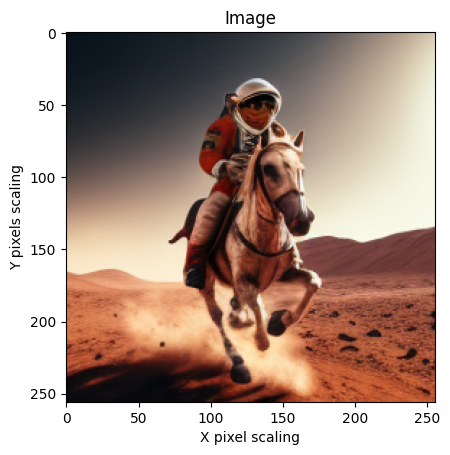


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 109.00it/s]


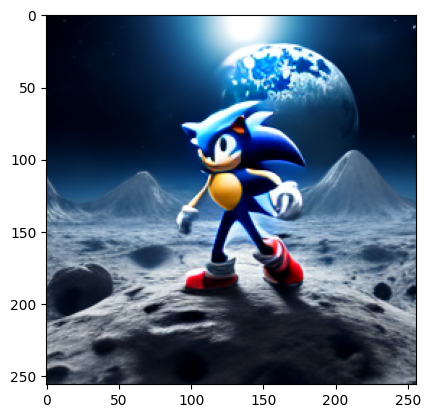


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 108.51it/s]


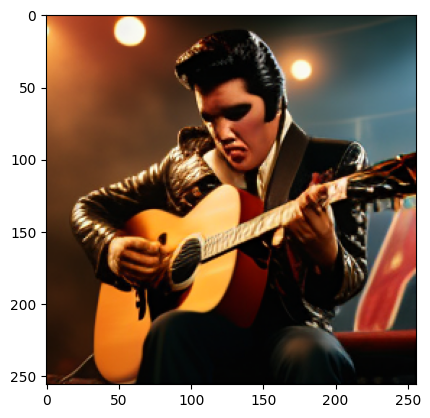


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 108.79it/s]


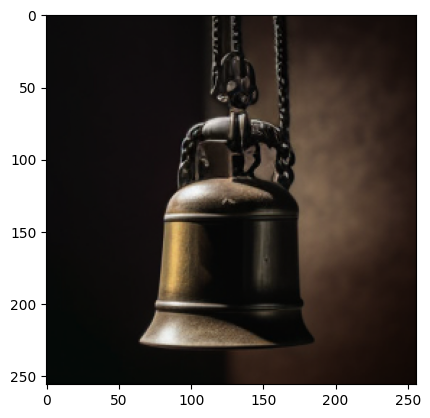


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 108.35it/s]


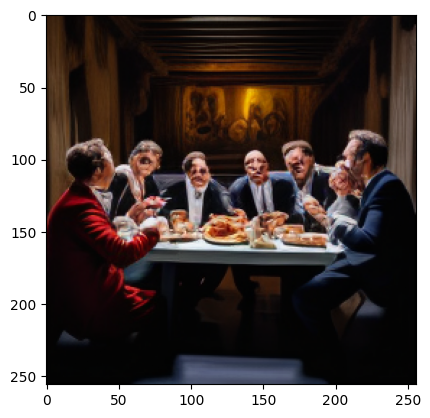


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 108.80it/s]


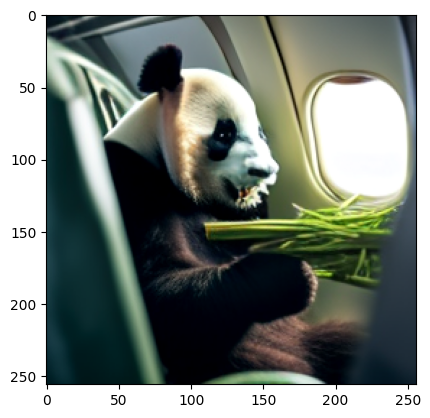


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 109.13it/s]


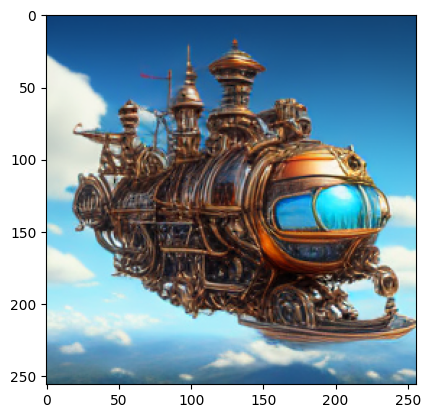


Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the Beautiful Soup library but it was not found in your environment. You can install it with pip:
`pip install beautifulsoup4`. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...
100%|██████████| 20/20 [00:00<00:00, 109.09it/s]


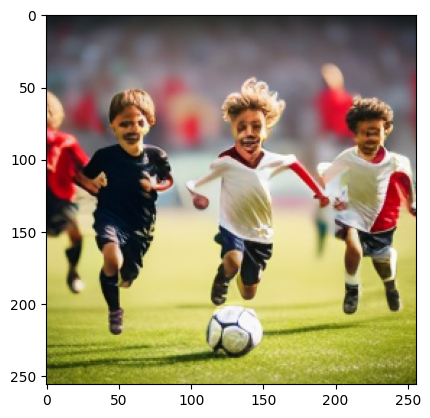

Average time:  0.42 seconds


In [12]:
# --- Load all compiled models ---
COMPILER_WORKDIR_ROOT = 'pixart_alpha_compile_dir'
text_encoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'text_encoder/model.pt')
decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_decoder/model.pt')
transformer_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'transformer/model.pt')
post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, 'vae_post_quant_conv/model.pt')

pipe = get_pipe(resolution, DTYPE)

_neuronTextEncoder = InferenceTextEncoderWrapper(DTYPE, pipe.text_encoder, seqlen)
_neuronTextEncoder.t = torch.jit.load(text_encoder_filename)
pipe.text_encoder = _neuronTextEncoder
assert pipe._execution_device is not None

device_ids = [0, 1]
_neuronTransformer = InferenceTransformerWrapper(pipe.transformer)
_neuronTransformer.transformer = torch_neuronx.DataParallel(torch.jit.load(transformer_filename), device_ids, set_dynamic_batching=False)
pipe.transformer = _neuronTransformer

pipe.vae.decoder = SimpleWrapper(torch.jit.load(decoder_filename))
pipe.vae.post_quant_conv = SimpleWrapper(torch.jit.load(post_quant_conv_filename))


# Run pipeline
prompt = [
  "a photo of an astronaut riding a horse on mars",
  "sonic on the moon",
  "elvis playing guitar while eating a hotdog",
  "saved by the bell",
  "engineers eating lunch at the opera",
  "panda eating bamboo on a plane",
  "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, trending in artstation, fantasy vivid colors",
  "kids playing soccer at the FIFA World Cup"
]

# First do a warmup run so all the asynchronous loads can finish
image_warmup = pipe(prompt[0]).images[0]

plt.title("Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

total_time = 0
for x in prompt:
  start_time = time.time()
  image = pipe(x).images[0]
  total_time = total_time + (time.time()-start_time)
  image.save("image.png")
  image = mpimg.imread("image.png")
  #clear_output(wait=True)
  plt.imshow(image)
  plt.show()
print("Average time: ", npy.round((total_time/len(prompt)), 2), "seconds")